# Opening the Black Box with LRP: A Hands-on Guide to Explainable AI for LLMs

by Reduan Achtibat & Anton Segeler


## Setup

We start by installing and importing the necessary libraries. We also set up the environment variables.



In [1]:
# installing packages with pip
#%pip install -r requirements.txt

In [2]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import modeling_llama
import gradio as gr
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jscatter import Scatter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
import ipywidgets as widgets
import umap
from tqdm import tqdm
import functools
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
%matplotlib inline

from utils.plotting import decode_tokens_for_plotting, jupyter_heatmap, plot_atlas

/home/messierandromeda/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Introduction: The Transformer Brain

In [3]:
HTML('assets/attention_viz.html') # If the visualization disappears, close and reopen the notebook

In [4]:
# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu"))

path = 'unsloth/Llama-3.2-1B-Instruct'

model = modeling_llama.LlamaForCausalLM.from_pretrained(
    path,
    device_map=device,
    dtype=torch.bfloat16, # to prevent numeric overflow! (float32/bfloat16 vs float16)
    attn_implementation="eager", # we need the attn weights!
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(path)

Since we are doing inference and attribution (not training), we freeze the model parameters to save memory and computation.

In [5]:
# Deactivate gradients on parameters
for param in model.parameters():
    param.requires_grad = False

# Prologue: Building Our Microscope

### 🧪 Experiment 1: Naive Perturbation


In [6]:
# Define the prompt
prompt = """\
NASA's CALIPSO satellite measured 182 million tons of Sahara dust annually, but recent studies suggest it's actually 27 million tons.
Q: How much dust is blown from the Sahara each year?
A: """

This function performs occlusion. It masks one token at a time and measures how much the probability of the target prediction drops. A large drop means the masked token was important.

In [7]:
@torch.no_grad()
def attribute_perturbation(model, tokenizer, prompt, baseline_token='_', target=None):
    """
    Perturbation attribution adapted for Causal LLMs (Llama, Mistral, etc.)
    """

    # 1. Prepare Input (Shape: [1, Sequence_Length])
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs.input_ids

    # Get the integer ID for the replacement token (underscore)
    # add_special_tokens=False ensures we get just the ID, not [BOS, ID]
    underscore_id = tokenizer(baseline_token, add_special_tokens=False).input_ids[0]

    # 2. Get Baseline Prediction (Original Logits)
    base_outputs = model(input_ids, use_cache=False)
    base_logits = base_outputs.logits # Shape: [1, Seq_Len, Vocab_Size]

    # We only care about the logits for the FINAL token (prediction of the next word)
    next_token_logits = base_logits[0, -1, :]

    # If no target provided, pick the model's top prediction
    if target is None:
        target = torch.argmax(next_token_logits).item()

    base_score = next_token_logits[target].item()

    # 3. Prepare Attribution Loop
    seq_len = input_ids.shape[1]
    attr = torch.zeros(seq_len)

    print(f"Target Token: '{tokenizer.decode([target])}' | Analyzing {seq_len} tokens...")

    # 4. Occlusion Loop
    for i in range(seq_len):
        # Create a copy of input_ids
        input_ids_occ = input_ids.clone()

        # Replace the i-th token with the underscore ID
        input_ids_occ[0, i] = underscore_id
        
        # Run model on occluded input
        occ_logits = model(input_ids_occ, use_cache=False).logits

        # Get score of the SAME target token at the LAST position
        occ_score = occ_logits[0, -1, target].item()

        # Attribution = How much did the score DROP when we removed this token?
        # (High positive value = Token was very important)
        attr[i] = base_score - occ_score

    # Normalize between [-1, 1]
    max_val = attr.abs().max()

    # Epsilon prevents division by zero if all scores are identical
    epsilon = 1e-9

    attr = attr / (max_val + epsilon)

    # Return attribution scores and the token ID that was targeted
    return attr.cpu().numpy(), target

In [8]:
# 1. Run the occlusion
pert_relevances, pert_target = attribute_perturbation(model, tokenizer, prompt)

# 2. Get the input IDs to decode them one by one
input_ids = tokenizer(prompt, return_tensors="pt").input_ids[0]
tokens = decode_tokens_for_plotting(input_ids, tokenizer)
jupyter_heatmap(tokens, pert_relevances, cmap='bwr')

Target Token: '182' | Analyzing 45 tokens...


## The Gradient Shortcut


### 🧪 Experiment 2: First-Order Taylor Approximation


Instead of masking tokens one by one (which is slow), we can use Input × Gradient. By computing the gradient of the target prediction with respect to the input embeddings, we measure how sensitive the model is to each specific token.

In [9]:
def attribute_input_x_gradient(model, tokenizer, prompt, target=None):
    """
    Computes Input * Gradient attribution for LLMs.
    Actually computes: DotProduct(Embedding, Gradient w.r.t Embedding)
    """

    # 1. Prepare Input and Embeddings
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs.input_ids

    # We must access embeddings directly to track gradients on them
    embedding_layer = model.get_input_embeddings()
    input_embeds = embedding_layer(input_ids).detach()
    input_embeds.requires_grad = True # CRITICAL: Enable gradient tracking

    # 2. Forward Pass
    outputs = model(inputs_embeds=input_embeds, use_cache=False)

    # Select target (Prediction of the last token)
    if target is None:
        target = torch.argmax(outputs.logits[0, -1, :]).item()

    # 3. Get the target score
    target_score = outputs.logits[0, -1, target]

    # 4. Backward Pass
    target_score.backward()

    # Gradients w.r.t the embeddings [1, Seq_Len, Hidden_Dim]
    grad = input_embeds.grad

    # 5. Input * Gradient Calculation
    # Element-wise multiplication followed by sum over the last hidden dimension
    # resulting in one scalar score per token.
    # output shape [batch_size, Seq_Len, Hidden_Dim]
    attr = (input_embeds * grad).float().sum(dim=-1)[0]

    # Normalize between [-1, 1]
    max_val = attr.abs().max()

    # Epsilon prevents division by zero if all scores are identical
    epsilon = 1e-9

    attr = attr / (max_val + epsilon)

    # Return attribution scores and the token ID that was targeted
    return attr.detach().cpu().numpy(), target

In [10]:
# Run Input x Gradient
ixg_relevances, ixg_target = attribute_input_x_gradient(model, tokenizer, prompt)

jupyter_heatmap(tokens, ixg_relevances, cmap='bwr')

### The Problem: Gradient Shattering


 While Gratient Analysis is faster, raw gradients can be "noisy" or shattered.

In [11]:
HTML('assets/gradient_noise.html')

## Removing the Noise with LRP

### 🧪 Experiment 3: Layer-wise Relevance Propagation


_Monkey Patching_ is a technique in dynamic programming languages (such as Python) for modifying or extending the behavior of modules, classes, or objects at runtime without changing the original source code.

In [12]:
# Modify the LLaMA module to compute LRP in the backward pass
from lxt.efficient import monkey_patch
from lxt.utils import clean_tokens

monkey_patch(modeling_llama, verbose=True)

Patched LlamaMLP
Patched LlamaRMSNorm
Patched Dropout
Patched transformers.models.llama.modeling_llama


Thanks to the LRP-patch, the resulting heatmap should look cleaner and more semantically meaningful than the raw gradients.

In [13]:
# Run LRP
lrp_relevances, lrp_target = attribute_input_x_gradient(model, tokenizer, prompt)

jupyter_heatmap(tokens, lrp_relevances, cmap='bwr')

In [14]:
def attribute_prediction(model, tokenizer, prompt, top_k=3):
    """
    Performs the forward pass and gradient calculation for top k tokens.
    Now accepts model and tokenizer explicitly.
    """
    top_k = int(top_k)
    model.eval()

    # Tokenization
    input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(model.device)
    embeddings = model.get_input_embeddings()(input_ids)

    # Enable gradients on embeddings
    embeddings.requires_grad_(True)

    # Forward Pass
    output = model(inputs_embeds=embeddings, use_cache=False)
    output_logits = output.logits

    # Select top k at the last token position
    max_logits, max_indices = torch.topk(output_logits[0, -1, :], dim=-1, k=top_k)

    results = {}
    tokens_text = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Assuming clean_tokens is defined elsewhere in your utils
    cleaned_tokens = clean_tokens(tokens_text)

    for i in range(top_k):
        target_token_id = max_indices[i]
        target_token_str = tokenizer.decode(target_token_id)
        score = max_logits[i]

        model.zero_grad()
        if embeddings.grad is not None:
            embeddings.grad.zero_()

        score.backward(retain_graph=True)

        r = (embeddings.grad * embeddings).float().sum(-1).squeeze().detach().cpu()
        r = r / r.abs().max()
        heatmap_data = list(zip(cleaned_tokens, r.numpy()))

        results[f"{target_token_str} (Logit: {score.item():.2f})"] = heatmap_data

    return results

def run_analysis(model, tokenizer, prompt, top_k):
    """Triggered when user clicks 'Analyze'"""
    if not prompt:
        return None, gr.Radio(choices=[]), []

    print(f"Analyzing '{prompt}' with Top-K={top_k}")

    # Pass model and tokenizer down to the interpretation logic
    results = attribute_prediction(model, tokenizer, prompt, top_k=top_k)
    keys = list(results.keys())

    return results, gr.Radio(choices=keys, value=keys[0], interactive=True), results[keys[0]]

def update_heatmap(selected_token, results):
    if selected_token in results:
        return results[selected_token]
    return []

def launch_relevance_visualizer(model, tokenizer, default_prompt="The capital of France is ", port=7873):
    """
    Args:
        model: The loaded HuggingFace model.
        tokenizer: The loaded HuggingFace tokenizer.
    """

    with gr.Blocks(title="LLM Relevance Heatmap") as demo:
        gr.Markdown("## LLM Token Relevance Visualizer with LRP")
        gr.Markdown("Enter a prompt to see top predicted next tokens and input relevance.")

        with gr.Row():
            with gr.Column(scale=1):
                prompt_input = gr.Textbox(label="Input Prompt", value=default_prompt, lines=2)
                top_k_slider = gr.Slider(minimum=1, maximum=10, value=3, step=1, label="Top K Predictions")
                analyze_btn = gr.Button("Calculate Relevance", variant="primary")
                prediction_selector = gr.Radio(choices=[], label="Predicted Next Token", interactive=True)

            with gr.Column(scale=2):
                heatmap_display = gr.HighlightedText(
                    label="Relevance Heatmap",
                    combine_adjacent=False,
                    show_legend=True,
                    color_map={"High Relevance": "#ff4b4b", "Medium Relevance": "#ff9f4b", "Low Relevance": "#ffe54b"}
                )

        analysis_state = gr.State()

        run_analysis_with_model = functools.partial(run_analysis, model, tokenizer)

        analyze_btn.click(
            fn=run_analysis_with_model,
            inputs=[prompt_input, top_k_slider],
            outputs=[analysis_state, prediction_selector, heatmap_display]
        )

        prediction_selector.change(
            fn=update_heatmap,
            inputs=[prediction_selector, analysis_state],
            outputs=[heatmap_display]
        )

    demo.launch(inline=True, server_port=port)
    return demo

The relevance scores are conditioned on the target. Changing the explained token alters the distribution of relevance across the input.

In [15]:
# Launch Gradio
demo = launch_relevance_visualizer(model, tokenizer, default_prompt=prompt, port=1313)

* Running on local URL:  http://127.0.0.1:1313
* To create a public link, set `share=True` in `launch()`.


# Main Act: The In-Context Learning Brain

This widget allows you to manually inspect the raw attention weights for any specific layer and head.


In [16]:
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions

In [17]:
attentions[0].shape

torch.Size([1, 32, 45, 45])

In [18]:
# Plot the attention maps
def visualize_llama_attention(text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions

    def plot_attention(layer_idx, head_idx):
        # Retrieve specific attention matrix
        # Layer shape: [batch, heads, seq_len, seq_len] -> select [0, head_idx, :, :]
        attn_map = attentions[layer_idx][0, head_idx].float().cpu().numpy()

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            attn_map,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis",
            square=True,
            cbar_kws={'label': 'Attention Weight'}
        )
        plt.title(f"Layer {layer_idx} | Head {head_idx}")
        plt.xlabel("Key Tokens (Attended To)")
        plt.ylabel("Query Tokens (Attending From)")
        plt.show()

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]

    layer_slider = widgets.IntSlider(value=0, min=0, max=num_layers-1, description='Layer:')
    head_slider = widgets.IntSlider(value=0, min=0, max=num_heads-1, description='Head:')

    ui = widgets.HBox([layer_slider, head_slider])
    out = widgets.interactive_output(plot_attention, {'layer_idx': layer_slider, 'head_idx': head_slider})

    display(ui, out)

# Run
visualize_llama_attention(prompt)

Output()

### 🧪 Experiment 4: Attention Head Relevance

We now switch from input relevance to component relevance. Instead of only looking at the gradients when they reach the inputs, we intercept them as they pass through the attention layers. By retaining the gradients at this intermediate stage, we can calculate Activation × Gradient for every specific head. This tells us not just what the model looked at, but which internal component was responsible for the predicted token.

In [19]:
def attribute_attn_heads(model, input_ids, target=None):
    """
    Computes Input * Gradient attribution for the last token position.
    Uses gradients from softmax outputs (attention weights).
    """
    # Get embeddings and enable gradient tracking
    embedding_layer = model.get_input_embeddings()
    inputs_embeds = embedding_layer(input_ids)
    inputs_embeds.requires_grad = True

    # Forward pass with attention outputs
    outputs = model(inputs_embeds=inputs_embeds, use_cache=False, output_attentions=True)

    # Retain gradients for attention weights (softmax outputs)
    for attn_layer in outputs.attentions:
        attn_layer.retain_grad()

    # If target is not given, use the predicted token
    if target is None:
        # Get the predicted token at last position (argmax of last position)
        target = torch.argmax(outputs.logits[0, -1, :]).item()

    target_score = outputs.logits[0, -1, target]

    # Backward pass
    model.zero_grad()
    target_score.backward()

    # Get attention gradients (if needed for additional analysis)
    attn_relevance = []
    attn_activation = []
    for attn_layer in outputs.attentions:
        activation = attn_layer.float().detach().cpu()
        attn_activation.append(activation)

        relevance = attn_layer * attn_layer.grad
        attn_relevance.append(relevance.float().detach().cpu())

    return torch.cat(attn_activation), torch.cat(attn_relevance), target

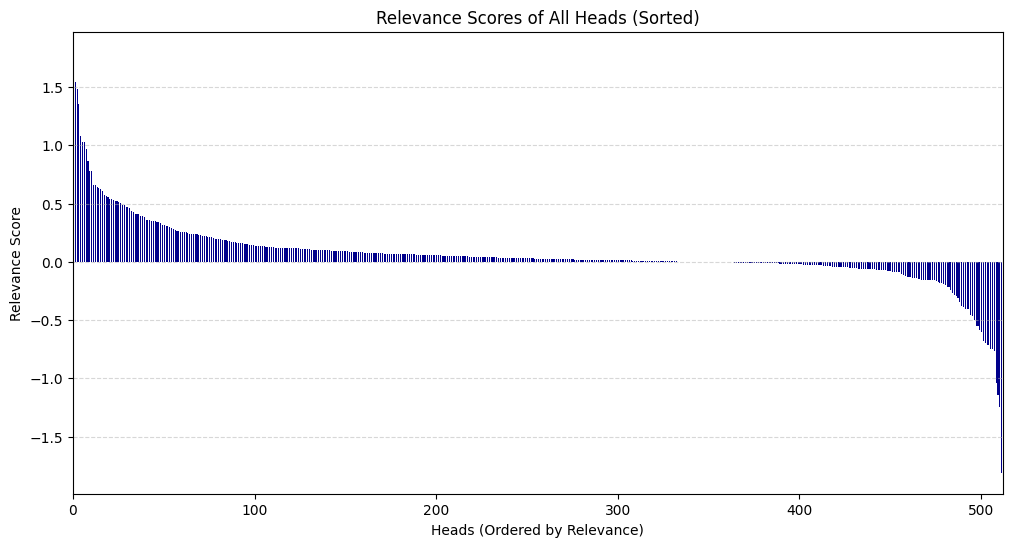

In [20]:
# Get input ids
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

# Calculate relevances per head and token
_, attn_relevance, _ = attribute_attn_heads(model, input_ids)

# Sum up relevances per head
attn_relevance = torch.sum(attn_relevance, dim=(-2, -1)).flatten() # shape: [num_heads] [512]

# Sort values in descending order (highest relevance first)
sorted_values = torch.sort(attn_relevance, descending=True).values.cpu().numpy()

# Plot the sorted values as a bar chart
plt.figure(figsize=(12, 6))

# Use bar chart to show each head as a distinct entity
plt.bar(range(len(sorted_values)), sorted_values, color='darkblue', width=0.6, align='edge')
plt.title('Relevance Scores of All Heads (Sorted)')
plt.xlabel('Heads (Ordered by Relevance)')
plt.ylabel('Relevance Score')

# Set x-axis limit to match the number of heads
plt.xlim(0, len(sorted_values))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

## 💡 1. Takeaway: Sparsity

We calculated the aggregate relevance of every attention head. The bar chart reveals that the vast majority of heads are not relevant, with only a few doing the heavy lifting.

## Clustering of Attention Weight Relevances

This function projects the attention heads into a 2D space (using UMAP) and clusters them (using KMeans) based on their relevance patterns.

In [21]:
# Cluster the attention maps

def attention_relevance_explorer(
    text,
    top_k=100,
    n_clusters=5,
    color_by='cluster'
):
    """
    Interactive attention relevance explorer using jscatter.

    Args:
        text: Input text to analyze
        top_k: Number of top heads to visualize
        n_clusters: Number of clusters for KMeans
        color_by: 'cluster' or 'layer'
    """
    print(f"--- Attention Relevance Explorer ---")
    print(f"1. Analyzing top {top_k} heads by relevance magnitude")
    print(f"2. Clustering into {n_clusters} groups")

    # Tokenize and encode
    encoded = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids[0])

    # Get relevance attribution
    print("3. Computing relevance (Input * Gradient)...")
    attn_activation, attn_relevance, target = attribute_attn_heads(model, encoded.input_ids.to(device))

    # Shape: [layers, heads, seq, seq] -> [layers * heads, seq, seq]
    num_layers = attn_relevance.shape[0]
    num_heads = attn_relevance.shape[1]
    attn_relevance = attn_relevance.reshape(num_layers * num_heads, attn_relevance.shape[2], attn_relevance.shape[3])

    print(f"   Predicted token: '{tokenizer.decode(target)}'")

    # Compute head-level scores (sum over all query-key positions)
    # Shape: [layers * heads, seq, seq] -> [layers * heads]
    head_relevance = torch.sum(attn_relevance, dim=(-1, -2))

    # Get top heads
    top_indices = torch.topk(head_relevance.flatten(), top_k).indices

    # Extract data for visualization
    visualization_data = []

    for idx in top_indices:
        idx = idx.item()
        layer = idx // num_heads
        head = idx % num_heads

        # Get full attention relevance map
        # Shape: [seq, seq] (queries x keys)
        attn_map = attn_relevance[idx].numpy()
        score = head_relevance[idx].item()

        visualization_data.append({
            'layer': layer,
            'head': head,
            'label': f"L{layer}-H{head}",
            'score': score,
            'attn_map': attn_map,
            'vector': attn_map.flatten()  # Flattened for UMAP
        })

    # Prepare data for UMAP (flatten 2D maps)
    X = np.array([d['vector'] for d in visualization_data])

    if len(X) < 2:
        print("(!) Error: Not enough heads for visualization.")
        return pd.DataFrame()

    # UMAP dimensionality reduction
    print("4. Running UMAP...")
    n_neighbors = min(15, len(X) - 1)
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=0.1,
        metric='cosine',
        random_state=42,
        n_jobs=1
    )
    embedding = reducer.fit_transform(X)

    # Create dataframe (exclude attn_map from df)
    df = pd.DataFrame([{k: v for k, v in d.items() if k not in ['attn_map', 'vector']} for d in visualization_data])
    df['x'] = embedding[:, 0]
    df['y'] = embedding[:, 1]

    # KMeans clustering
    if n_clusters > 1:
        print(f"5. Clustering with KMeans (k={n_clusters})...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        df['cluster'] = kmeans.fit_predict(embedding)
    else:
        df['cluster'] = 0

    # Determine coloring
    if color_by == 'cluster' and n_clusters > 1:
        color_col = 'cluster'
        cmap = 'tab10'
    else:
        color_col = 'layer'
        cmap = 'viridis'

    # Create metadata dataframe for scatter
    df_meta = df.copy()

    # Interactive visualization
    print("6. Creating interactive plot...")

    detail_view = widgets.Output(
        layout={'border': '1px solid gray', 'width': '50%', 'height': '600px', 'overflow': 'auto'}
    )

    def update_detail_view(change):
        selection = change['new']
        detail_view.clear_output(wait=True)

        with detail_view:
            if not selection:
                print("Click a point to see the full attention relevance map.\n")
                print("Y-axis: Query positions (which token is attending)")
                print("X-axis: Key positions (which token is attended to)")
                return

            idx = selection[0]
            data = visualization_data[idx]
            attn_map = data['attn_map']

            cluster_label = f" | Cluster {df.iloc[idx]['cluster']}" if n_clusters > 1 else ""

            fig, ax = plt.subplots(figsize=(12, 10))

            # Plot heatmap with diverging colormap (red-blue)
            attn_map = attn_map / abs(attn_map).max()
            im = ax.imshow(attn_map, cmap='RdBu_r', aspect='auto', interpolation='nearest', vmin=-1, vmax=1)

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, label='Relevance (Activation × Gradient)')

            # Set title
            ax.set_title(
                f"{data['label']}{cluster_label}\nTotal Relevance Score: {data['score']:.4f}",
                fontsize=12,
                pad=20
            )

            # Set axis labels
            ax.set_ylabel("Query Position (Token)", fontsize=10)
            ax.set_xlabel("Key Position (Token)", fontsize=10)

            # Set ticks and labels
            seq_len = len(tokens)
            tick_positions = list(range(seq_len))
            ax.set_yticks(tick_positions)
            ax.set_yticklabels(tokens, fontsize=8)
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)

            # Add grid for better readability
            ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='gray')

            plt.tight_layout()
            plt.show()

    # Create scatter plot
    scatter = Scatter(
        data=df_meta,
        x='x',
        y='y',
        color_by=color_col,
        colormap=cmap,
        size=10,
        height=500,
        opacity=0.9,
        tooltip=True,
        legend=True,
        background_color='white',
        axes=True
    )

    scatter.widget.observe(update_detail_view, names='selection')

    # Display
    display(HTML("""
        <style>
        .white-bg-fix {
            background-color: white !important;
            color: black !important;
        }
        </style>
    """))

    container = widgets.HBox([scatter.show(), detail_view])
    container.add_class("white-bg-fix")
    display(container)

    print("\n✓ Done! Click on points to explore full attention head relevance maps.")
    print("   Heatmap: Y-axis = Queries, X-axis = Keys")

    return df_meta[['layer', 'head', 'label', 'score', 'cluster', 'x', 'y']]

In [22]:
# Run
df_results = attention_relevance_explorer(
    text=prompt,
    top_k=150,
    n_clusters=20,
    color_by='cluster'
)

--- Attention Relevance Explorer ---
1. Analyzing top 150 heads by relevance magnitude
2. Clustering into 20 groups
3. Computing relevance (Input * Gradient)...
   Predicted token: '182'
4. Running UMAP...
5. Clustering with KMeans (k=20)...
6. Creating interactive plot...



✓ Done! Click on points to explore full attention head relevance maps.
   Heatmap: Y-axis = Queries, X-axis = Keys


## 💡 2. Takeaway: Functional Specialization
The clustering shows that attention heads are specialized. Just as the brain has distinct regions for vision and language, the Transformer has distinct clusters of heads for different tasks.


## Function Vectors: The Causal Test


### 🧪 Experiment 5: Task Head Transplantation


We define hooks to intervene in the model's forward pass. This allows us to transplant the output of specific attention heads from one context to another.

In [23]:
def create_hook(head_ids, function_vectors, model_config, scaling):
    """Creates a hook to manipulate attention head outputs.
    
    Args:
        head_ids: List of head indices within this layer
        function_vectors: Tensor of shape [batch, seq_len, num_heads, head_dim]
        model_config: Model configuration
        scaling: Scaling factor for function vectors
    """
    def manipulate_input(module, input, output):
        # input[0] is attention output: [batch, seq_len, hidden_size]
        bsz, q_len, hidden_size = input[0].shape
        num_heads = model_config.num_attention_heads
        head_dim = hidden_size // num_heads
        
        # Reshape to separate heads: [batch, seq_len, num_heads, head_dim]
        attn_output = input[0].view(bsz, q_len, num_heads, head_dim)
        
        # Replace specified heads at last position with scaled function vectors
        attn_output[:, -1, head_ids] = function_vectors[:, -1] * scaling
        
        # Reshape back and apply output projection
        attn_output = attn_output.reshape(bsz, q_len, hidden_size)
        return torch.nn.functional.linear(attn_output, module.weight, module.bias)
    
    return manipulate_input


def patch_function_vectors_(model, inputs, head_ids, scaling=2):
    """Patches function vectors from head_ids into the model.
    
    Args:
        model: LlamaForCausalLM model
        inputs: Input token IDs from seed prompt
        head_ids: List of global head IDs to patch
        scaling: Scaling factor for function vectors
        
    Returns:
        handles: List of hook handles for cleanup
    """
    num_heads_per_layer = model.config.num_attention_heads
    head_dim = model.config.hidden_size // num_heads_per_layer
    
    # Group heads by layer
    head_dict = {}
    for head_id in head_ids:
        layer_id = head_id // num_heads_per_layer
        head_dict.setdefault(layer_id, []).append(head_id)
    
    # Capture attention outputs from relevant layers
    o_proj_inputs_cache = {}
    
    def capture_o_proj_input(layer_id):
        def hook(module, input, output):
            o_proj_inputs_cache[layer_id] = input[0].detach().clone()
        return hook
    
    # Register capture hooks
    capture_handles = [
        model.model.layers[layer_id].self_attn.o_proj.register_forward_hook(
            capture_o_proj_input(layer_id)
        )
        for layer_id in head_dict.keys()
    ]
    
    # Run forward pass to capture activations
    model(input_ids=inputs, use_cache=False)
    
    # Remove capture hooks
    for handle in capture_handles:
        handle.remove()
    
    # Register manipulation hooks
    handles = []
    for layer_id, global_head_ids in head_dict.items():
        # Extract function vectors for this layer's heads
        o_proj_input = o_proj_inputs_cache[layer_id]
        
        # Convert global head IDs to layer-local indices
        local_head_ids = [h_id % num_heads_per_layer for h_id in global_head_ids]
        
        # Extract and stack function vectors: [batch, seq_len, num_heads, head_dim]
        function_vectors = torch.stack([
            o_proj_input[:, :, h_idx * head_dim:(h_idx + 1) * head_dim]
            for h_idx in local_head_ids
        ], dim=2)
        
        # Register manipulation hook
        handle = model.model.layers[layer_id].self_attn.o_proj.register_forward_hook(
            create_hook(local_head_ids, function_vectors, model.config, scaling)
        )
        handles.append(handle)
    
    return handles

We patch the vectors from our identified clusters into a new prompt (about the Atlantic Ocean) to see if we can trigger specific behaviors causally.

In [24]:
# 1. Setup
unique_clusters = sorted(df_results['cluster'].unique())
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

num_heads = model.config.num_attention_heads
target_prompt = "The Atlantic Ocean is the second-largest ocean on Earth. It holds about 310 million cubic kilometers of water." \
"It spans a wide range of marine biomes, from warm tropical coral reef systems near the equator to cold, nutrient-rich polar waters in the north and south. " \
"These biomes support diverse life, including plankton, fish, whales, and deep-sea organisms, and play a major role in regulating Earth's climate through ocean currents like the Gulf Stream." \
"Q: Which biomes does it support?\nA: "


# 2. Prepare Inputs
# A. Source Input
inputs_source = tokenizer(prompt, return_tensors="pt").to(model.device)

# B. Target Input
inputs_target = tokenizer(target_prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

# 3. Normal Generation
print("\n" + "=" * 60)
print("BASELINE: Target Generation (No Patching)")
print("=" * 60)
generated_ids = model.generate(input_ids=inputs_target.input_ids, do_sample=False, max_new_tokens=50)
decoded_normal = tokenizer.decode(generated_ids[0, inputs_target.input_ids.shape[1]:], skip_special_tokens=True)
print(decoded_normal.strip())
print("\n" + "#" * 80 + "\nSTARTING CLUSTER INTERVENTIONS\n" + "#" * 80 + "\n")

# 4. Cluster Loop
for cluster_id in unique_clusters:
    print(f"PROCESSING CLUSTER: {cluster_id}")

    # A. Filter for Current Cluster
    cluster_data = df_results[df_results['cluster'] == cluster_id]

    # B. Calculate Global IDs
    head_ids_to_patch = (cluster_data['layer'] * num_heads + cluster_data['head']).tolist()

    # Configuration for this run
    scaling = 2.0

    print(f" -> Patching {len(head_ids_to_patch)} heads: {head_ids_to_patch}")

    # C. Patched Generation
    handles = patch_function_vectors_(model, inputs_source.input_ids, head_ids_to_patch, scaling=scaling)

    generated_ids = model.generate(input_ids=inputs_target.input_ids, do_sample=False, max_new_tokens=50)
    print(generated_ids.shape)
    decoded_patched = tokenizer.decode(generated_ids[0, inputs_target.input_ids.shape[1]:], skip_special_tokens=True)

    print("-" * 40)
    print(f"PATCHED OUTPUT (Cluster {cluster_id})")
    print("-" * 40)
    print(decoded_patched.strip())

    # D. Remove hooks
    for h in handles:
        h.remove()
    print(f"[Hooks removed]\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Found 20 clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19)]

BASELINE: Target Generation (No Patching)
tropical coral reef systems
B:  cold, nutrient-rich polar waters
C:  warm tropical coral reef systems and cold, nutrient-rich polar waters
D:  warm tropical coral reef systems and deep-sea organisms
Answer: C The correct

################################################################################
STARTING CLUSTER INTERVENTIONS
################################################################################

PROCESSING CLUSTER: 0
 -> Patching 12 heads: [387, 425, 10, 504, 382, 195, 185, 32, 104, 152, 113, 162]
torch.Size([1, 155])
----------------------------------------
PATCHED OUTPUT (Cluster 0)
----------------------------------------
310 million cubic

This function identifies which attention heads are most relevant with respect to a specific substring.

In [25]:
attentions[0].shape

torch.Size([1, 32, 45, 45])

In [26]:
def get_topk_heads_on_substring(text, search_string, top_k=20, verbose=False):
    """
    Analyzes attention heads focusing on a substring.

    Returns:
        tuple: (head_ids, df)
            - head_ids (list): List of global head IDs [int]
            - df (pd.DataFrame): Data with columns ['layer', 'head', 'score', 'type']
    """
    # 1. Tokenize
    encoded = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids[0])

    # 2. Find substring tokens
    search_encoded = tokenizer(search_string, add_special_tokens=False)
    search_tokens = tokenizer.convert_ids_to_tokens(search_encoded.input_ids)

    # Find matching token indices
    key_indices = []
    for i in range(len(tokens) - len(search_tokens) + 1):
        match = True
        for j, search_tok in enumerate(search_tokens):
            token_clean = tokens[i + j].replace('▁', '').replace('Ġ', '').lower()
            search_clean = search_tok.replace('▁', '').replace('Ġ', '').lower()
            if token_clean != search_clean:
                match = False
                break
        if match:
            key_indices.extend(range(i, i + len(search_tokens)))

    key_indices = sorted(list(set(key_indices)))

    # Handle missing substring
    if not key_indices:
        if verbose:
            print(f"Warning: Could not find tokens for '{search_string}'")
        return [], pd.DataFrame(columns=['layer', 'head', 'score', 'type'])

    if verbose:
        print(f"Found substring at positions {key_indices}: {[tokens[i] for i in key_indices]}")

    # 3. Get relevance
    _, attn_relevance, target = attribute_attn_heads(model, encoded.input_ids.to(device))

    # Reshape to [layers * heads, seq, seq]
    num_layers = attn_relevance.shape[0]
    num_heads = attn_relevance.shape[1]
    attn_relevance = attn_relevance.reshape(num_layers * num_heads, attn_relevance.shape[2], attn_relevance.shape[3])

    # 4. Calculate Scores
    last_query_relevance = attn_relevance[:, -1, :]
    substring_relevance = last_query_relevance[:, key_indices].clamp(min=0).sum(dim=-1)

    # 5. Extract Top-K
    top_results = torch.topk(substring_relevance, top_k)
    top_indices = top_results.indices
    top_scores = top_results.values

    # 6. Build Outputs
    head_ids = top_indices.tolist()
    results_data = []

    for idx_tensor, score_tensor in zip(top_indices, top_scores):
        global_idx = idx_tensor.item()
        score = score_tensor.item()

        layer = global_idx // num_heads
        head = global_idx % num_heads

        results_data.append({
            'layer': int(layer),
            'head': int(head),
            'score': score,
            'type': search_string
        })

        if verbose and len(results_data) <= 10:
             print(f"  L{layer}-H{head} (ID={global_idx}): {score:.4f}")

    df = pd.DataFrame(results_data)

    return head_ids, df

We identify heads responsible for the task and patch them into the target prompt to see if we can force the model to answer a different question.

In [27]:
# Get heads focusing on the Task

input_ids_seed = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(device)

HEAD_IDS, df_task = get_topk_heads_on_substring(
    text=prompt,
    search_string="Q: How much dust is blown from the Sahara each year",
    top_k=10,
    verbose=True
)

print(f"\nHead IDs: {HEAD_IDS}")

Found substring at positions [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]: ['Q', ':', 'ĠHow', 'Ġmuch', 'Ġdust', 'Ġis', 'Ġblown', 'Ġfrom', 'Ġthe', 'ĠSahara', 'Ġeach', 'Ġyear']
  L9-H25 (ID=313): 0.2806
  L0-H28 (ID=28): 0.1583
  L8-H29 (ID=285): 0.1270
  L10-H12 (ID=332): 0.1109
  L8-H7 (ID=263): 0.1104
  L0-H23 (ID=23): 0.0936
  L9-H24 (ID=312): 0.0806
  L9-H13 (ID=301): 0.0776
  L10-H9 (ID=329): 0.0739
  L9-H14 (ID=302): 0.0639

Head IDs: [313, 28, 285, 332, 263, 23, 312, 301, 329, 302]


In [28]:
# Patch these heads into the Atlantic Ocean prompt
input_ids_target = tokenizer(target_prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

# Normal generation
generated_ids = model.generate(input_ids=input_ids_target.input_ids, do_sample=False, max_new_tokens=10)
print("Normal:", tokenizer.decode(generated_ids[0, input_ids_target.input_ids.shape[1]:]))

# Patched generation
try:
    handles = patch_function_vectors_(model, input_ids_seed, HEAD_IDS, scaling=2.0)
    generated_ids = model.generate(input_ids=input_ids_target.input_ids, do_sample=False, max_new_tokens=50)
    print("Patched:", tokenizer.decode(generated_ids[0, input_ids_target.input_ids.shape[1]:]))
finally:
    [h.remove() for h in handles]

Normal:  tropical coral reef systems
B:  cold,
Patched: 310 million cubic kilometers of water
B: 200 million cubic kilometers of water
C: 300 million cubic kilometers of water
D: 310 million cubic kilometers of water
The correct answer is C: 310 million cubic kilometers of water


We can also identify heads used for translation and patch them into a non-translation prompt.

In [29]:
# Translation
seed_prompt_translation   = """\
Task: Translation into German: I love AI research
Answer:"""

input_ids_seed = tokenizer(seed_prompt_translation, return_tensors="pt", add_special_tokens=True).input_ids.to(device)

HEAD_IDS, df_translation = get_topk_heads_on_substring(
    text=seed_prompt_translation,
    search_string="Translation into German",
    top_k=10,
    verbose=True
)

print(f"\nHead IDs: {HEAD_IDS}")

Found substring at positions [3, 4, 5]: ['ĠTranslation', 'Ġinto', 'ĠGerman']
  L8-H25 (ID=281): 1.1968
  L9-H2 (ID=290): 0.3339
  L9-H23 (ID=311): 0.2294
  L15-H7 (ID=487): 0.1576
  L8-H12 (ID=268): 0.1523
  L9-H13 (ID=301): 0.1488
  L13-H4 (ID=420): 0.1466
  L6-H18 (ID=210): 0.1316
  L8-H30 (ID=286): 0.1207
  L2-H26 (ID=90): 0.1093

Head IDs: [281, 290, 311, 487, 268, 301, 420, 210, 286, 90]


In [30]:
# Patch these heads into a new prompt
target_prompt_translation = "Write the opposite of this sentence: The car is going very fast.\nAnswer: "
inputs_test = tokenizer(target_prompt_translation, return_tensors="pt", add_special_tokens=True).to(model.device)

# Normal generation
generated_ids = model.generate(input_ids=inputs_test.input_ids, do_sample=False, max_new_tokens=20)
print("Normal:", tokenizer.decode(generated_ids[0, inputs_test.input_ids.shape[1]:]))

# Patched generation
try:
    handles = patch_function_vectors_(model, input_ids_seed, HEAD_IDS, scaling=3.0)
    generated_ids = model.generate(input_ids=inputs_test.input_ids, do_sample=False, max_new_tokens=50)
    print("Patched:", tokenizer.decode(generated_ids[0, inputs_test.input_ids.shape[1]:]))
finally:
    [handle.remove() for handle in handles]

Normal:  The car is going very slowly.<|eot_id|>
Patched:  Der Auto ist sehr schnell. (Der) ist sehr schnell. (Es ist sehr schnell.)

Von "der" ist "sich" (sich) "der" ist "sich" (sich) "der" ist "


### 🧪 Experiment 6: Retrieval Head Manipulation


We isolate the specific heads responsible for retrieving the answer "182 million tons."

In [31]:
# Get heads focusing on "182 million tons"
input_ids_seed = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(device)

HEAD_IDS, df_retrival = get_topk_heads_on_substring(
    text=prompt,
    search_string="182 million tons",
    top_k=10,
    verbose=True
)

print(f"\nHead IDs: {HEAD_IDS}")

Found substring at positions [9, 10, 11]: ['182', 'Ġmillion', 'Ġtons']
  L15-H30 (ID=510): 1.7969
  L14-H15 (ID=463): 1.5156
  L11-H14 (ID=366): 1.3672
  L14-H22 (ID=470): 1.0709
  L15-H22 (ID=502): 0.7969
  L10-H26 (ID=346): 0.6265
  L14-H29 (ID=477): 0.5820
  L10-H24 (ID=344): 0.5205
  L14-H12 (ID=460): 0.5040
  L10-H13 (ID=333): 0.4087

Head IDs: [510, 463, 366, 470, 502, 346, 477, 344, 460, 333]


In [32]:
# Patch these heads into the Atlantic Ocean prompt
inputs_test = tokenizer(target_prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

# Normal generation
generated_ids = model.generate(input_ids=inputs_test.input_ids, do_sample=False, max_new_tokens=10)
print("Normal:", tokenizer.decode(generated_ids[0, inputs_test.input_ids.shape[1]:]))

# Patched generation
try:
    handles = patch_function_vectors_(model, input_ids_seed, HEAD_IDS, scaling=1.0)
    generated_ids = model.generate(input_ids=inputs_test.input_ids, do_sample=False, max_new_tokens=50)
    print("Patched:", tokenizer.decode(generated_ids[0, inputs_test.input_ids.shape[1]:]))
finally:
    [h.remove() for h in handles]

Normal:  tropical coral reef systems
B:  cold,
Patched: 182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182182


Let's see where these heads are located throughout the model layers

/home/messierandromeda/xai4llms/utils/plotting.py:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plot = df_plot.groupby(color_col, group_keys=False).apply(


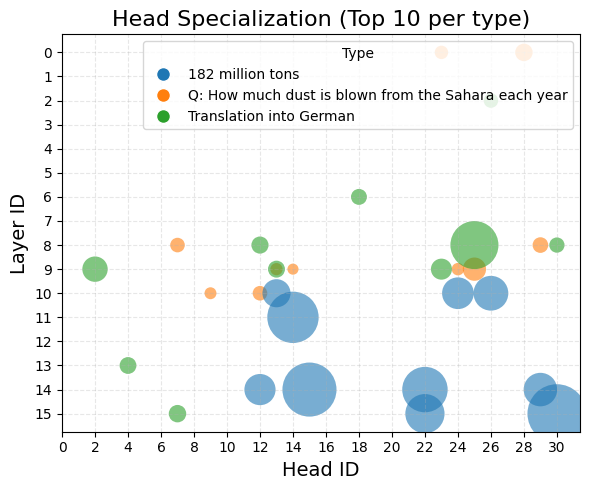

In [33]:
# Plot Atlas for task heads and retrival heads

# Combine dfs
df_combined = pd.concat([df_task, df_translation, df_retrival], ignore_index=True)

# Plot
plot_atlas(df_combined, color_col='type', size_col='score',top_k=10)

## 💡 3. Takeaway: Distributed Representation

When we map these heads, a clear depth-wise organization emerges. Task Heads are primarily found in the middle layers, acting as the processing engine. In contrast, Retrieval Heads are concentrated in the later layers, refining the information just before the final output


## The Parametric Knowledge Brain: A Different World


### 🧪 Experiment 7: Knowledge Conflict


We define a dataset of "Counterfactual" examples (e.g., "The capital of France is London") where the provided context contradicts the model's internal (parametric) knowledge.

In [34]:
SAMPLES = [
    # Geography
    {'param_answer': 'Paris', 'context_answer': 'London',
     'prompt': "The capital of France is London.\nQ: What is the capital of France? A: The capital of France is"},
    {'param_answer': 'Berlin', 'context_answer': 'Paris',
     'prompt': "The capital of Germany is Paris.\nQ: What is the capital of Germany? A: The capital of Germany is"},
    {'param_answer': 'Rome', 'context_answer': 'Milan',
     'prompt': "The capital of Italy is Milan.\nQ: What is the capital of Italy? A: The capital of Italy is"},

    # Brands
    {'param_answer': 'Apple', 'context_answer': 'Samsung',
     'prompt': "The iPhone is made by Samsung.\nQ: Who makes the iPhone? A: The iPhone is made by"},
    {'param_answer': 'Tesla', 'context_answer': 'Ford',
     'prompt': "Elon Musk runs Ford.\nQ: What company does Elon Musk run? A: Elon Musk runs"},
    {'param_answer': 'Google', 'context_answer': 'Yahoo',
     'prompt': "Yahoo owns YouTube.\nQ: Who owns YouTube? A: YouTube is owned by"},

    # Colors
    {'param_answer': 'white', 'context_answer': 'green',
     'prompt': "The color of snow is green.\nQ: What is the color of snow? A: The color of snow is"},
    {'param_answer': 'blue', 'context_answer': 'red',
     'prompt': "The color of the sky is red.\nQ: What is the color of the sky? A: The color of the sky is"},
    {'param_answer': 'yellow', 'context_answer': 'purple',
     'prompt': "The color of the sun is purple.\nQ: What is the color of the sun? A: The color of the sun is"},

    # Math
    {'param_answer': '4', 'context_answer': '5',
     'prompt': "2 + 2 = 5.\nQ: What is 2 + 2? A: 2 + 2 ="},
    {'param_answer': '6', 'context_answer': '7',
     'prompt': "3 + 3 = 7.\nQ: What is 3 + 3? A: 3 + 3 ="},
    {'param_answer': '10', 'context_answer': '11',
     'prompt': "5 + 5 = 11.\nQ: What is 5 + 5? A: 5 + 5 ="},

    # Animals
    {'param_answer': 'dog', 'context_answer': 'cat',
     'prompt': "A cat barks.\nQ: What animal barks? A: A"},
    {'param_answer': 'cat', 'context_answer': 'dog',
     'prompt': "A dog meows.\nQ: What animal meows? A: A"},
    {'param_answer': 'cow', 'context_answer': 'goat',
     'prompt': "A goat gives milk on farms.\nQ: What farm animal gives lots of milk? A: A"},
]

In [35]:
def find_matching_token_in_top_k(word, top_tokens, tokenizer):
    tokens = tokenizer.tokenize(word)
    if len(tokens) == 0:
        return None, None

    first_token = tokens[0]
    if first_token in top_tokens:
        return first_token, top_tokens.index(first_token)

    variations = [first_token, ' ' + word[:len(first_token)]]
    for var in variations:
        if var in top_tokens:
            return var, top_tokens.index(var)

    return None, None

We run attribution on these samples to find which heads support the context answer vs. which heads support the parametric answer.

In [36]:
# Process training samples (simplified, no intermediate `r` dict)
TOP_HEADS = 25
print(f"\nProcessing {len(SAMPLES)} training samples...\n")

param_relevance, context_relevance = [],[]

for i, sample in enumerate(SAMPLES):
    input_ids = tokenizer(sample['prompt'], return_tensors='pt').input_ids.to(model.device)

    with torch.inference_mode():
        logits = model(input_ids).logits[0, -1]

    top_ids = torch.topk(logits, 10).indices.tolist()
    top_tokens = [tokenizer.decode([idx]).strip() for idx in top_ids]

    param_match, param_idx = find_matching_token_in_top_k(sample['param_answer'], top_tokens, tokenizer)
    context_match, context_idx = find_matching_token_in_top_k(sample['context_answer'], top_tokens, tokenizer)

    if param_match is not None:
        _, attn_relevance, _ = attribute_attn_heads(model, input_ids, target=top_ids[param_idx])
        param_relevance.append(torch.sum(attn_relevance, dim=(-2, -1)))

    if context_match is not None:
        _, attn_relevance, _ = attribute_attn_heads(model, input_ids, target=top_ids[context_idx])
        context_relevance.append(torch.sum(attn_relevance, dim=(-2, -1)))


param_relevance = torch.stack(param_relevance)
context_relevance = torch.stack(context_relevance)

print("✓ Done processing training samples.")
print(f"Shape of param_relevance {param_relevance.shape} and context_relevance {context_relevance.shape}\n")


Processing 15 training samples...

✓ Done processing training samples.
Shape of param_relevance torch.Size([13, 16, 32]) and context_relevance torch.Size([11, 16, 32])



We use PCA to visualize the head relevances. This shows a clear separation between heads that focus on context and heads that focus on internal memory.

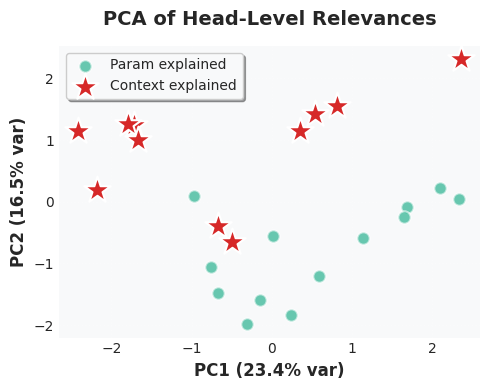

In [37]:
# Set style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'

# Prepare data for PCA
X_param = param_relevance.reshape(len(param_relevance), -1).cpu().numpy()
X_ctx = context_relevance.reshape(len(context_relevance), -1).cpu().numpy()
X = np.vstack([X_param, X_ctx])

# Fit PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(X)
pca_param = pca.transform(X_param)
pca_ctx = pca.transform(X_ctx)

# Create figure
fig, ax = plt.subplots(figsize=(5, 4))

# Plot PCA with enhanced styling
scatter1 = ax.scatter(pca_param[:, 0], pca_param[:, 1], 
                      c='#06A77D', label='Param explained', 
                      s=80, alpha=0.6, edgecolors='white', linewidth=1.5)
scatter2 = ax.scatter(pca_ctx[:, 0], pca_ctx[:, 1], 
                      c='#D62828', marker='*', s=400, 
                      label='Context explained', edgecolors='white', linewidth=1.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', 
              fontsize=12, fontweight='bold')
ax.set_title('PCA of Head-Level Relevances', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(frameon=True, shadow=True, fontsize=10, loc='best')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

## Contrastive XAI

We calculate a difference score (Parametric - Contextual) to identify the specific heads that are most strongly associated with each type of knowledge.

Selected Heads (L-H): [(11, 25), (9, 23), (10, 14), (12, 15), (11, 4), (12, 2), (10, 22), (10, 15), (11, 27), (15, 6), (11, 10), (9, 0), (14, 13), (11, 22), (9, 3), (8, 13), (8, 24), (11, 26), (10, 8), (9, 4), (8, 18), (11, 23), (6, 31), (13, 30), (4, 8), (14, 30), (14, 15), (11, 8), (15, 7), (8, 14), (12, 13), (10, 23), (14, 2), (12, 3), (9, 1), (10, 20), (10, 24), (7, 25), (8, 20), (11, 5), (10, 11), (15, 4), (10, 17), (4, 11), (9, 12), (10, 13), (5, 19), (14, 14), (10, 25), (9, 22)]


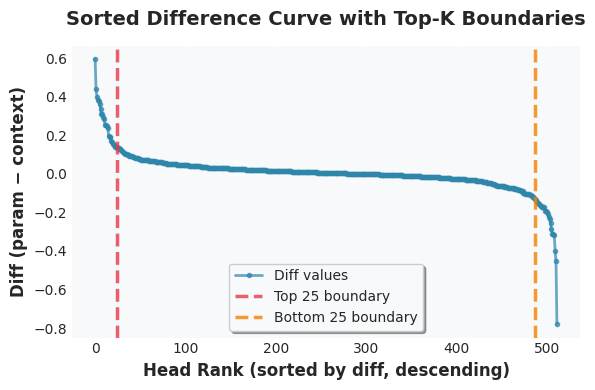

In [38]:
# GOAL: assigns a score to each attention head individually, indicating whether it is more relevant for parameter-based or context-based predictions.

# Reminder: param_relevance.shape = (num_samples, num_layer, num_heads)
#           context_relevance.shape = (num_samples, num_layer, num_heads)
diff = param_relevance.mean(dim=0) - context_relevance.mean(dim=0)

diff_flat = diff.flatten()
num_heads = diff.shape[1]

top_pos_idx = torch.topk(diff_flat, TOP_HEADS).indices
top_neg_idx = torch.topk(diff_flat, TOP_HEADS, largest=False).indices
selected_idx = torch.cat([top_pos_idx, top_neg_idx])

selected_heads = [(idx.item() // num_heads, idx.item() % num_heads) for idx in selected_idx]
print(f"Selected Heads (L-H): {selected_heads}")


# Set style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'

# Sorted diff curve and TOPK vertical lines
diff_flat = diff.flatten().cpu().numpy()
sorted_vals = np.sort(diff_flat)[::-1]  # descending

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot sorted diff curve
ax.plot(sorted_vals, marker='o', linestyle='-', alpha=0.7, 
        linewidth=2, markersize=3, color='#2E86AB', label='Diff values')
ax.axvline(x=TOP_HEADS - 0.5, color='#E63946', linestyle='--', 
           linewidth=2.5, label=f'Top {TOP_HEADS} boundary', alpha=0.8)
ax.axvline(x=len(sorted_vals) - TOP_HEADS - 0.5, color='#F77F00', 
           linestyle='--', linewidth=2.5, label=f'Bottom {TOP_HEADS} boundary', alpha=0.8)

ax.set_xlabel('Head Rank (sorted by diff, descending)', fontsize=12, fontweight='bold')
ax.set_ylabel('Diff (param − context)', fontsize=12, fontweight='bold')
ax.set_title('Sorted Difference Curve with Top-K Boundaries', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(frameon=True, shadow=True, fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

By plotting the contrastive scores, we see a physical separation between the two types of knowledge. Parametric Heads (Red) tend to cluster in the very early and late layers, suggesting they are involved in initial processing and final output generation. In contrast, In-Context Heads (Blue) dominate the middle-to-late layers, where the model performs complex reasoning and integration of the provided text.

/home/messierandromeda/xai4llms/utils/plotting.py:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plot = df_plot.groupby(color_col, group_keys=False).apply(


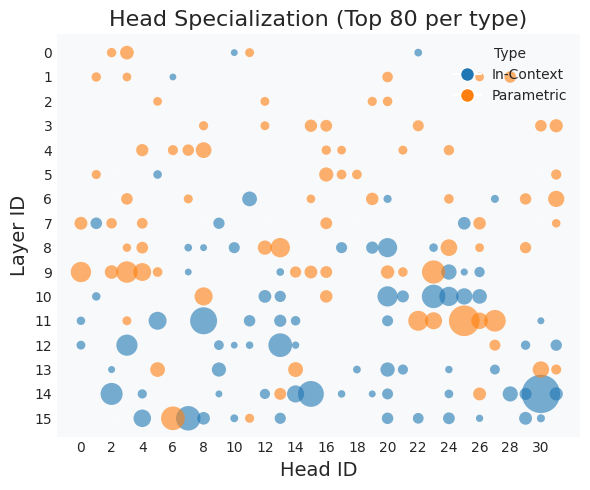

In [39]:
# Plot atlas for In-Context and Parametric Heads

# Let's take only positive relevances into account to focus on supportive heads
diff = param_relevance.clamp(min=0).mean(dim=0) - context_relevance.clamp(min=0).mean(dim=0)

# Prepare Data for DataFrame
diff_scores = diff.cpu()
num_layers, num_heads = diff_scores.shape
layers = np.repeat(np.arange(num_layers), num_heads)
heads = np.tile(np.arange(num_heads), num_layers)

# Flatten scores
raw_scores = diff_scores.flatten().numpy()

# Determine Head Type (Positive = In-Context, Negative = Parametric)
head_types = np.where(raw_scores > 0, 'Parametric', 'In-Context')

# Take Magnitudes (Absolute value)
magnitudes = np.abs(raw_scores)

# 5. Create DataFrame
df = pd.DataFrame({
    'layer': layers,
    'head': heads,
    'score': magnitudes,     # Magnitude for dot size
    'type': head_types  # Categorical for color
})
plot_atlas(df, color_col='type', size_col='score',top_k=80)

## Monitoring System

We train a Linear Discriminant Analysis (LDA) classifier to automatically detect if a head is behaving "parametrically" or "contextually."

In [40]:
# Train LDA classifier on provided "parametric" (true_mean) and "contextual" (wrong_mean) examples
X_param = param_relevance.reshape(param_relevance.shape[0], -1)[:, selected_idx].detach().cpu().numpy()
X_ctx = context_relevance.reshape(context_relevance.shape[0], -1)[:, selected_idx].detach().cpu().numpy()

X_train = np.concatenate([X_param, X_ctx])
y_train = np.concatenate([np.ones(X_param.shape[0], dtype=int), np.zeros(X_ctx.shape[0], dtype=int)])

print(f"Training data shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Class counts: parametric={int(y_train.sum())}, contextual={int((y_train==0).sum())}")

lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

loo = LeaveOneOut()
correct = 0
for train_idx, test_idx in loo.split(X_train):
    lda.fit(X_train[train_idx], y_train[train_idx])
    pred = lda.predict(X_train[test_idx])[0]
    correct += int(pred == y_train[test_idx][0])

loo_accuracy = correct / len(X_train)
print(f"  LDA Leave-One-Out Accuracy: {loo_accuracy:.3f}\n")

# Train on full training data
lda.fit(X_train, y_train)
print("LDA classifier trained on full dataset")


Training data shape: (24, 50), labels shape: (24,)
Class counts: parametric=13, contextual=11
  LDA Leave-One-Out Accuracy: 1.000

LDA classifier trained on full dataset


We generate a medical report and use our trained LDA classifier to analyze every single predicted token. This determines if the information came from the context (the patient record) or the model's internal memory (potential hallucination).

In [41]:
# Apply to Medical Text - TOKEN LEVEL
print("\n" + "="*100)
print("PART 2: CLASSIFYING GENERATED MEDICAL TEXT - TOKEN BY TOKEN")
print("="*100)

record = """
PATIENT RECORD - John Smith, Age 45

Chief Complaint: Chest pain, shortness of breath
History: Hypertension (diagnosed 2019), smoker (20 years)
Current Medications: Lisinopril 10mg daily
Vitals: BP 145/95, HR 88, Temp 98.6°F
Lab Results: Pending
Physical Exam: Mild chest discomfort on palpation
Patient Reports: Pain started 3 hours ago, radiating to left arm"""

messages = [
    {"role": "system", "content": "You are a medical assistant."},
    {"role": "user", "content": f"{record}\n\nWrite a comprehensive handover summary for the ward team. Include what to monitor and why."}
]

print("\nGenerating medical handover summary...")
input_ids = tokenizer.apply_chat_template(
    messages, return_tensors="pt", tokenize=True, 
    add_special_tokens=True, add_generation_prompt=True
).to(model.device)
input_length = input_ids.shape[1]

torch.manual_seed(42)
np.random.seed(42)

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        max_new_tokens=300,
        do_sample=True,
    )

full_sequence = output_ids[0]
generated_tokens = full_sequence[input_length:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print("\n" + "-"*100)
print("GENERATED TEXT:")
print("-"*100)
print(generated_text)
print("-"*100)


# TOKEN-LEVEL CLASSIFICATION
def classify_tokens(model, input_ids, generated_tokens):
    """Compute attention relevance for a specific token position"""

    token_classifications = []

    input_ids = input_ids.clone()
    embeds = model.get_input_embeddings()(input_ids.unsqueeze(0))
    embeds.requires_grad = True

    outputs = model(inputs_embeds=embeds, use_cache=False, output_attentions=True)

    for attn in outputs.attentions:
        attn.retain_grad()

    print(f"\nClassifying {len(generated_tokens)} tokens...\n")

    for i in tqdm(range(len(generated_tokens))):
        token_id = generated_tokens[i].item()
        token_text = tokenizer.decode([token_id])
        abs_position = input_length + i
        
        if abs_position >= len(full_sequence):
            continue
        
        # Target the logit for this specific token at this position
        target_token_id = input_ids[abs_position]
        target_logit = outputs.logits[0, abs_position - 1, target_token_id]

        model.zero_grad()
        for attn in outputs.attentions:
            if attn.grad is not None:
                attn.grad.zero_()

        target_logit.backward(retain_graph=True)
        
        relevances = []
        for l_idx, h_idx in selected_heads:
            attn = outputs.attentions[l_idx]
            rel = (attn[0, h_idx] * attn.grad[0, h_idx]).float().sum(dim=[-2, -1]).item()
            relevances.append(rel)

        features = np.array(relevances).reshape(1, -1)
        
        # Get probabilities
        probabilities = lda.predict_proba(features)[0]
        prob_contextual = probabilities[0]  # Class 0
        prob_parametric = probabilities[1]  # Class 1
        
        # Classify
        prediction = lda.predict(features)[0]
        class_label = 'parametric' if prediction == 1 else 'contextual'
        
        token_classifications.append({
            'token': token_text,
            'token_id': token_id,
            'position': i,
            'prob_contextual': prob_contextual,
            'prob_parametric': prob_parametric,
            'class': class_label
        })

    return token_classifications

token_classifications = classify_tokens(model, full_sequence, generated_tokens)


PART 2: CLASSIFYING GENERATED MEDICAL TEXT - TOKEN BY TOKEN

Generating medical handover summary...

----------------------------------------------------------------------------------------------------
GENERATED TEXT:
----------------------------------------------------------------------------------------------------
**Handover Summary: John Smith, Ward Team**

**Patient Information:**

* Name: John Smith
* Age: 45
* Chief Complaint: Chest pain, shortness of breath
* History: Hypertension (diagnosed 2019), smoker (20 years)
* Current Medications: Lisinopril 10mg daily
* Vitals: BP 145/95, HR 88, Temp 98.6°F
* Lab Results: Pending
* Physical Exam: Mild chest discomfort on palpation

**Current Situation:**

John Smith is currently experiencing chest pain and shortness of breath, which started 3 hours ago and radiates to his left arm. He reports a 3-hour history of chest discomfort. The patient's vital signs are within normal limits, but his BP is slightly elevated.

**Monitoring and Rec

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [41:28<00:00,  8.29s/it]


In [42]:
# COLOR-CODED VISUALIZATION (contextual=blue, parametric=red)

print("\n" + "-"*100)
print("ORIGINAL PATIENT RECORD:")
print("-"*100)
print(record)
print("-"*100)


def get_color_for_prob(prob_parametric):
    """
    Return ANSI color code based on parametric probability.
    Red (parametric) -> Yellow (mixed) -> Blue (contextual)
    """
    if prob_parametric > 0.7:
        return "\033[31m"  # Bright red / strong parametric
    elif prob_parametric > 0.6:
        return "\033[91m"  # Red
    elif prob_parametric > 0.5:
        return "\033[93m"  # Yellow (mixed)
    elif prob_parametric > 0.4:
        return "\033[33m"  # Dark yellow (mixed)
    elif prob_parametric > 0.3:
        return "\033[94m"  # Bright blue (contextual-leaning)
    else:
        return "\033[34m"  # Blue (strongly contextual)

RESET = "\033[0m"

print("\n" + "="*120)
print("TOKEN-LEVEL CLASSIFICATION WITH COLOR CODING")
print("="*120)
print(f"Classifier: Linear Discriminant Analysis (LDA)")
print(f"Training LOO Accuracy: {loo_accuracy:.3f}")
print("="*120)
print("\nColor Legend:")
print(f"\033[31m██\033[0m Bright Red: Strongly Parametric (P > 0.7)")
print(f"\033[91m██\033[0m Red: Parametric (P > 0.6)")
print(f"\033[93m██\033[0m Yellow: Mixed (0.4 < P ≤ 0.6)")
print(f"\033[94m██\033[0m Bright Blue: Contextual-leaning (P > 0.3)")
print(f"\033[34m██\033[0m Blue: Strongly Contextual (P ≤ 0.3)")
print("="*120)
print("\nCOLOR-CODED TEXT:")
print("-"*120)

# Print with colors
colored_text = ""
for tc in token_classifications:
    color = get_color_for_prob(tc['prob_parametric'])
    colored_text += f"{color}{tc['token']}{RESET}"

print(colored_text)
print("-"*120)


----------------------------------------------------------------------------------------------------
ORIGINAL PATIENT RECORD:
----------------------------------------------------------------------------------------------------

PATIENT RECORD - John Smith, Age 45

Chief Complaint: Chest pain, shortness of breath
History: Hypertension (diagnosed 2019), smoker (20 years)
Current Medications: Lisinopril 10mg daily
Vitals: BP 145/95, HR 88, Temp 98.6°F
Lab Results: Pending
Physical Exam: Mild chest discomfort on palpation
Patient Reports: Pain started 3 hours ago, radiating to left arm
----------------------------------------------------------------------------------------------------

TOKEN-LEVEL CLASSIFICATION WITH COLOR CODING
Classifier: Linear Discriminant Analysis (LDA)
Training LOO Accuracy: 1.000

Color Legend:
██ Bright Red: Strongly Parametric (P > 0.7)
██ Red: Parametric (P > 0.6)
██ Yellow: Mixed (0.4 < P ≤ 0.6)
██ Bright Blue: Contextual-leaning (P > 0.3)
██ Blue: Strongly Co